In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
from sympy.utilities import lambdify
import matplotlib.pyplot as plt

## Smooth dynamics

In [2]:
# numeric parameters
nominal_parameters = {}
mc = sp.symbols('m_c') # mass cart
nominal_parameters[mc] = 1.
mp = sp.symbols('m_p') # mass pole
nominal_parameters[mp] = 1.
l = sp.symbols('l') # length pole
nominal_parameters[l] = 1.
d = sp.symbols('d') # distance walls from origin
nominal_parameters[d] = .5
g = sp.symbols('g') # gravity acceleration
nominal_parameters[g] = 10.
g_vec = sp.Matrix([0., -g])

In [3]:
# state
[qc, qp, qcd, qpd] = sp.symbols('q_c q_p \dot{q}_c \dot{q}_p')
q = sp.Matrix([qc, qp])
qd = sp.Matrix([qcd, qpd])
x = sp.Matrix([q, qd])

# input
fc = sp.symbols('f_c')
fc_vec = sp.Matrix([fc, 0])

# contact forces
[flw, frw] = sp.symbols('f_{lw} f_{rw}')
flw_vec = sp.Matrix([flw, 0])
frw_vec = sp.Matrix([-frw, 0])

# all the external forces
f = sp.Matrix([fc, flw, frw])

In [4]:
# positions
pc = sp.Matrix([qc, 0])
pp = sp.Matrix([qc-l*sp.sin(qp), l*sp.cos(qp)])

In [5]:
# velocities
vc = pc.jacobian(q)*qd
vp = pp.jacobian(q)*qd

In [7]:
# lagrangian function
T = .5*mc*(vc.T*vc) + .5*mp*(vp.T*vp)
T.simplify()
U = - mp*(g_vec.T*pp)
L = T - U

In [8]:
# mass matrix
M = L.jacobian(qd).T.jacobian(qd)

# Coriolis, centrifugal, and gravitational terms
c = L.jacobian(qd).T.jacobian(q)*qd - L.jacobian(q).T

# generalized forces
Q = pc.jacobian(q).T*fc_vec + \
    pp.jacobian(q).T*flw_vec + \
    pp.jacobian(q).T*frw_vec

In [9]:
# nonlinear dynamics
rhs = M.inv()*(- c + Q)
rhs.simplify()
rhs = sp.Matrix([qd, rhs])

In [10]:
# equibirium
subs = {
    **{xi: 0. for i, xi in enumerate(x)},
    **{fi: 0. for i, fi in enumerate(f)}
}

# linearized dynamics
A = rhs.jacobian(x).subs(subs)
B = rhs.jacobian(f).subs(subs)
A.simplify()
B.simplify()
print(B)

Matrix([[0, 0, 0], [0, 0, 0], [1.0/m_c, 0, 0], [1.0/(l*m_c), -1.0/(l*m_p), 1.0/(l*m_p)]])


In [11]:
M

Matrix([
[  1.0*m_c + 1.0*m_p, -1.0*l*m_p*cos(q_p)],
[-1.0*l*m_p*cos(q_p),        1.0*l**2*m_p]])

## Simulation

In [10]:
stiffness = 100.
damping = 30.
gap_sym = {
    'l': pp[0] + d,
    'r': d - pp[0]
}
gap_nom = {k: v.subs(nominal_parameters) for k, v in gap_sym.items()}
gap_fun = {k: lambdify([x], v, 'numpy') for k, v in gap_nom.items()}
f_sym = {
    'l': - stiffness*gap_sym['l'] - damping*vp[0],
    'r': - stiffness*gap_sym['r'] + damping*vp[0]
}
f_nom = {k: v.subs(nominal_parameters) for k, v in f_sym.items()}
f_fun = {k: lambdify([x], v, 'numpy') for k, v in f_nom.items()}

In [11]:
rhs_nom = rhs.subs(nominal_parameters)
rhs_fun = sp.utilities.lambdify([x, f], rhs_nom, 'numpy')

def x_dot(x, fc):
    inputs = [fc]
    for wall in ['l','r']:
        if gap_fun[wall](x) > 0. or f_fun[wall](x) < 0.:
            inputs.append(0.)
        else:
            inputs.append(f_fun[wall](x))
    return rhs_fun(x, inputs).flatten()

def simulate(x, T, h, fc=0.):
    x_list = [x]
    for t in range(T):
        x_list.append(x_list[-1] + h*x_dot(x_list[-1], fc))
    return np.array(x_list)

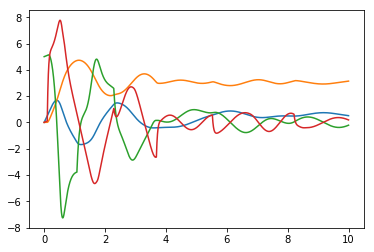

In [31]:
h_sim = .001
T_sim = int(10./h_sim)
x_list = simulate(np.array([0.,0.,5.,0.]), T_sim, h_sim, 1.)
for i in range(len(x)):
    plt.plot(np.linspace(0., T_sim*h_sim, T_sim+1), x_list[:,i])

In [18]:
from visualizer import vis, animate
vis.jupyter_cell()

In [19]:
animate(x_list, h_sim)